In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
# filepath = os.path.join('/home/dude/Desktop/data/email_data', 'full_dataset.csv')  LINUX
filepath = os.path.join('/Users/misham/Desktop/data/email_data', 'full_dataset.csv')

In [3]:
df = pd.read_csv(filepath)

In [4]:
df.dropna(axis=0, inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27082 entries, 0 to 27081
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   subject  27082 non-null  object 
 1   body     27082 non-null  object 
 2   label    27082 non-null  float64
dtypes: float64(1), object(2)
memory usage: 634.9+ KB


In [6]:
df['label'] = df['label'].astype('int64')

In [7]:
df['label'].value_counts()

label
0    19165
1     7917
Name: count, dtype: int64

In [8]:
total = len(df)
ham_amt = int(df['label'].value_counts().iloc[0])
spam_amt = int(df['label'].value_counts().iloc[1])

percentage_of_spam = round(spam_amt / total, 2)
percentage_of_ham = round(ham_amt / total, 2)

In [9]:
percentage_of_spam

0.29

In [10]:
percentage_of_ham

0.71

In [11]:
from nltk.corpus import stopwords

In [12]:
stop_words = stopwords.words('english')

In [13]:
df['body'] = df['body'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop_words))

In [14]:
df['subject'] = df['subject'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop_words))

In [15]:
df.head()

,subject,body,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,query : letter frequencies text identification,posting inquiry sergei atamas ( satamas @ umab...,0
2,risk,colleague researching differing degrees risk p...,0
3,request book information,earlier morning phone friend mine living south...,0
4,call abstracts : optimality syntactic theory,content - length : 4437 call papers best good ...,0


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [17]:
# Combine Subject and Body
df['text'] = df['subject'] + " " + df['body']

X = df['text']
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
vectorizer = TfidfVectorizer()

In [19]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, accuracy_score, PrecisionRecallDisplay

In [23]:
def all_metrics(true, pred, **kwargs):
    name = kwargs.get('name', None)
    print(f"Metrics for {name}")
    print(f"Recall ---> {round(recall_score(true, pred), 2)}")
    print(f"Precision ---> {round(precision_score(true, pred), 2)}")
    print(f"Accuracy ---> {round(accuracy_score(true, pred), 2)}")

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3848
           1       0.98      0.92      0.95      1569

    accuracy                           0.97      5417
   macro avg       0.97      0.96      0.97      5417
weighted avg       0.97      0.97      0.97      5417



In [25]:
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[3816,   32],
       [ 118, 1451]])

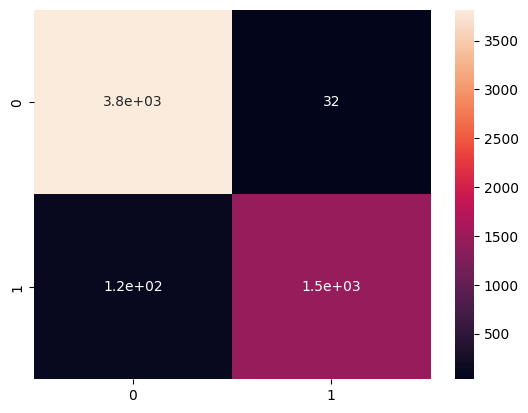

In [26]:
sns.heatmap(cf_matrix, annot=True)
plt.show()

In [27]:
all_metrics(y_test, y_pred, name='Logistic Regression')

Metrics for Logistic Regression
Recall ---> 0.92
Precision ---> 0.98
Accuracy ---> 0.97


In [28]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [29]:
lin_svc = LinearSVC(dual='auto')

In [30]:
param_grid = {
    'C':[0.1, 1, 2, 5]
}

In [31]:
grid_search = GridSearchCV(lin_svc, param_grid, n_jobs=10, verbose=1, cv=5)

In [32]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=10,
             param_grid={'C': [0.1, 1, 2, 5]}, verbose=1)

In [33]:
grid_search.best_params_

{'C': 1}

In [34]:
best_svm = grid_search.best_estimator_

In [35]:
best_svm.fit(X_train, y_train)

LinearSVC(C=1)

In [36]:
y_pred = best_svm.predict(X_test)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3848
           1       0.98      0.96      0.97      1569

    accuracy                           0.98      5417
   macro avg       0.98      0.98      0.98      5417
weighted avg       0.98      0.98      0.98      5417



In [38]:
all_metrics(y_test, y_pred, name='Linear SVM Classifer')

Metrics for Linear SVM Classifer
Recall ---> 0.96
Precision ---> 0.98
Accuracy ---> 0.98


In [39]:
from joblib import load, dump

In [40]:
# dump(best_svm, 'model.joblib')

In [41]:
# dump(vectorizer, 'vectorizer.joblib')

### Using BERT Vectorizer

In [42]:
from transformers import BertTokenizer, BertModel
import torch

In [43]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [44]:
print(tokenizer(df['text'].iloc[0]))

Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


{'input_ids': [101, 3105, 14739, 1011, 6207, 1011, 26354, 2470, 2415, 4180, 1011, 3091, 1024, 27908, 2575, 6207, 1011, 26354, 2470, 2415, 2149, 1002, 2184, 2454, 4101, 6957, 6207, 3274, 4297, 1012, 2820, 3001, 2671, 2120, 2118, 5264, 1010, 2284, 5264, 1010, 2559, 1024, 3026, 4613, 7155, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 3144, 4018, 2470, 11532, 15078, 15397, 1010, 2164, 3019, 2653, 6364, 1008, 1008, 2394, 1008, 1008, 1008, 1008, 2822, 1008, 1008, 7778, 2653, 11643, 1012, 3716, 2110, 1011, 1997, 1011, 1996, 1011, 2396, 13931, 1011, 2241, 1050, 1011, 13250, 2653, 4275, 1010, 17053, 2653, 4275, 1010, 2112, 1011, 1997, 1011, 4613, 2653, 4275, 3223, 1012, 3793, 1011, 1011, 4613, 2622, 3003, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 314

In [51]:
def encode_batch(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()  # Get the embeddings of the [CLS] token


In [52]:
X = df['text'].tolist()
y = df['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
def process_in_batches(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_embeddings = encode_batch(batch)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)  # Stack all the embeddings vertically

In [54]:
batch_size = 100

In [55]:
X_train_embeddings = process_in_batches(X_train, batch_size=batch_size)
X_test_embeddings = process_in_batches(X_test, batch_size=batch_size)

KeyboardInterrupt: 